In [42]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

**Data generation**

In [106]:
sys.path.insert(0, os.path.join("..", "tdlearn"))

In [107]:
sys.path.insert(0, os.path.join("..", "tdlearn", "util"))

In [108]:
# repo from https://github.com/chrodan/tdlearn
from tdlearn import examples
from tdlearn import features
from tdlearn import policies

In [6]:
n = 400 # |S|
n_a = 10
n_feat = 200 # d
mdp = examples.RandomMDP(n, n_a)
phi = features.lin_random(n_feat, n, constant=True)
gamma = .95
np.random.seed(3)
beh_pol = policies.Discrete(np.random.rand(n, n_a))
tar_pol = policies.Discrete(np.random.rand(n, n_a))

In [7]:
from task import LinearDiscreteValuePredictionTask

task = LinearDiscreteValuePredictionTask(mdp, gamma, phi, np.zeros(phi.dim),
                                         policy=beh_pol, target_policy=tar_pol)

In [10]:
Phi = task.Phi

### Check the equal methods of multidim dot

In [ ]:
_C = np.zeros((n_feat, n_feat))
for s in range(n):
    _C += Phi[s].T.dot(Phi[s])

In [ ]:
_C

array([[132.3901114 ,  97.76274183, 102.33712169, ..., 101.92788541,
         97.90852101, 198.62850564],
       [ 97.76274183, 133.84740882, 105.41928405, ..., 103.89166623,
        101.36922797, 199.80451165],
       [102.33712169, 105.41928405, 140.99246525, ..., 106.10621796,
        107.04401561, 207.82468526],
       ...,
       [101.92788541, 103.89166623, 106.10621796, ..., 138.4972571 ,
        103.59722151, 203.98860115],
       [ 97.90852101, 101.36922797, 107.04401561, ..., 103.59722151,
        138.57030077, 204.7450469 ],
       [198.62850564, 199.80451165, 207.82468526, ..., 203.98860115,
        204.7450469 , 400.        ]])

In [ ]:
C = np.tensordot(Phi[:, None, :], Phi[..., None], axes=([0,1], [0,2]))

In [ ]:
np.isclose(C,_C).all()

True

### Experiment setting

In [269]:
_states, _actions, _n_states, _rewards = [], [], [], []
N = 20000
for s, a, _s, r in task.mdp.sample_transition(max_n=N, policy=beh_pol, seed=None,
                                              with_restart=True, s_start=None):
    _states.append(s)
    _actions.append(a)
    _n_states.append(_s)
    _rewards.append(r)

In [270]:
C = np.tensordot(Phi[_states, None, :], Phi[_states, :, None], axes=([0,1], [0,2]))

In [271]:
b = np.asarray(np.array(_rewards).dot(Phi[_states, :]))

In [272]:
B = C - gamma*np.tensordot(Phi[_states, None, :], 
                           Phi[np.hstack([_states[1:], _states[-1]]), :, None], axes=([0,1], [0,2]))

In [290]:
import lib.utils as ut


class RL_problem(pr.BaseSaddle):
    def __init__(self, B, C, b, rho=1.):
        L_xy = 1
        mu_xy = 0.25
        mu_yx = 0.25
        A = -B
        super().__init__(A=A)
        self.A = A
        spectrum = LA.eig(self.A.T.dot(self.A))[0]
        self.L_xy = spectrum.real.max()**.5
        self.mu_yx = np.abs(spectrum).min()**.5 
        self.mu_xy = np.abs(LA.eig(self.A.dot(self.A.T))[0]).min()**.5
        self.C = C
        self.C_inv = LA.inv(self.C)
        self.b = b
        n = self.A.shape[0]
        
        self.rho = rho
        self.f = lambda x: self.rho*0.5*x.transpose() @ x
        self.g = lambda y:  0.5*y.transpose() @ self.C @ y - self.b.transpose().squeeze() @ y
        self.L_x = self.rho
        self.mu_x = self.rho
        
        spectrum = LA.eig(self.C)[0]
        self.L_y = spectrum.max()
        self.mu_y = spectrum.real.min() 
        if self.rho == 0:
            self.yopt = LA.solve(self.A.transpose(), np.zeros((n, 1))) 
            self.xopt = LA.solve(self.A, self.C.dot(self.yopt) - self.b)
        else:
            self.yopt = LA.solve(self.C + 1/self.rho*self.A @ self.A.T, self.b) 
            self.xopt = LA.solve(np.eye(n), -1/self.rho * self.A.T.dot(self.yopt))
            
        self.constraint=False   
        self.grad_f = grad(self.f)
        self.grad_g = grad(self.g)  
        self.d2fdxdx = grad(self.grad_f)
        self.F = lambda x, y: self.f(x) + y.T @ self.A @ x - self.g(y)
        self.dFdx = grad(self.F)
        self.dFdy = grad(self.F, 1)
        
    def MSPBE_loss(self, x, y):
        return 0.5 * ((self.A.dot(x) - self.b.squeeze()).T.dot(self.C_inv).dot(self.A.dot(x) - self.b.squeeze()))

In [300]:
A=-B
RHO = LA.svd(A.T.dot(LA.inv(C)).dot(A))[1].max()
# RHO = 1.
problem_RL = RL_problem(B=B,C=C, b=b.T, rho=RHO)
params = {"apdg": None,
          # 'altgd': 0.1,
          # 'simgd': 0.05,
          # 'avg': 1,
          # 'eg':0.6,
          # 'omd':0.3,
          # 'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )
type2=True
iteration = 10000
k =  100
methods_dict = ut.main(problem_RL, iteration, x0.copy(), y0.copy(), params, k=k)

APDG: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 693.66it/s]


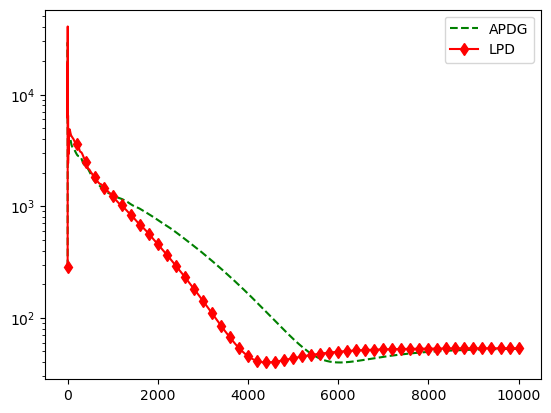

In [303]:
%matplotlib inline
plot_interval = 1
markevery=200
for method in methods_dict:
    if method not in ["EG", "OMD", "SimGD", "AltGD"]:
        plt.semilogy(np.arange(0, iteration+plot_interval, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
plt.legend()

In [296]:
ut.display_constants(problem_RL)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [297]:
problem_RL.mu_y

6.407935212564885

In [298]:
problem_RL.mu_xy

6.323007059264595

In [299]:
problem_RL.mu_yx

6.323007058781291